<a href="https://colab.research.google.com/github/AmlanAlok/instacart-2017-project/blob/PCA-Analysis/Instacart_2017_PCA_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [400]:
# For data manipulation
import pandas as pd    
import xgboost
from sklearn.model_selection import train_test_split
import time

import numpy as np # algebra & calculus
from google.colab import drive
drive.mount('/content/drive/')

%cd 'drive/MyDrive/9-Projects/1-ML-Instacart'

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# Garbage Collector to free up memory
import gc                         
gc.enable()

cluster_count = 3

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/9-Projects/1-ML-Instacart'
/content/drive/MyDrive/9-Projects/1-ML-Instacart


In [401]:
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
products = pd.read_csv("products.csv")
orders = pd.read_csv("orders_50.csv")
prior = pd.read_csv("op_prior_50.csv")
train = pd.read_csv("op_train_50.csv")
# orders = pd.read_csv("orders_100.csv")
# order_products_prior = pd.read_csv("op_prior_100.csv")
# order_products_train = pd.read_csv("op_train_100.csv")
# orders = pd.read_csv("orders.csv")
# order_products_prior = pd.read_csv("order_products__prior.csv")
# order_products_train = pd.read_csv("order_products__train.csv")

print("aisles: ",aisles.shape)
print("departments: " ,departments.shape)
print("orders: ",orders.shape)
print("products: ",products.shape)
print("order_products_prior: ",prior.shape)
print("order_products_train: ",train.shape)

aisles:  (134, 2)
departments:  (21, 2)
orders:  (831792, 7)
products:  (49688, 4)
order_products_prior:  (7882503, 4)
order_products_train:  (334239, 4)


In [402]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831792 entries, 0 to 831791
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                831792 non-null  int64  
 1   user_id                 831792 non-null  int64  
 2   eval_set                831792 non-null  object 
 3   order_number            831792 non-null  int64  
 4   order_dow               831792 non-null  int64  
 5   order_hour_of_day       831792 non-null  int64  
 6   days_since_prior_order  781793 non-null  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 44.4+ MB


In [403]:
prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7882503 entries, 0 to 7882502
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 240.6 MB


In [404]:
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')


orders['order_dow'] = orders['order_dow'].astype('int8')
orders['order_hour_of_day'] = orders['order_hour_of_day'].astype('int8')
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype('float16')
orders['user_id'] = orders['user_id'].astype('int32')
orders['order_id'] = orders['order_id'].astype('int32')
prior['order_id'] = prior['order_id'].astype('int32')
prior['product_id'] = prior['product_id'].astype('int16')
prior['add_to_cart_order'] = prior['add_to_cart_order'].astype('int8')
prior['reordered'] = prior['reordered'].astype('int8')

In [405]:
print('orders.shape =', orders.shape)
orders.head()

orders.shape = (831792, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [406]:
order_prior = pd.merge(prior,orders,on=['order_id','order_id'])
order_prior = order_prior.sort_values(by=['user_id','order_id'])
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
991482,431534,196,1,1,1,prior,5,4,15,28.0
991483,431534,12427,2,1,1,prior,5,4,15,28.0
991484,431534,10258,3,1,1,prior,5,4,15,28.0
991485,431534,25133,4,1,1,prior,5,4,15,28.0
991486,431534,10326,5,0,1,prior,5,4,15,28.0


In [407]:
_mt = pd.merge(prior,products, on = ['product_id','product_id'])
_mt = pd.merge(_mt,orders,on=['order_id','order_id'])
_mt = pd.merge(_mt,departments,on=['department_id','department_id'])
mt = pd.merge(_mt,aisles,on=['aisle_id','aisle_id'])
mt.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
0,6,15873,2,0,Dryer Sheets Geranium Scent,75,17,22352,prior,4,1,12,30.0,household,laundry
1,125669,15873,5,0,Dryer Sheets Geranium Scent,75,17,11895,prior,2,3,14,7.0,household,laundry
2,258957,15873,8,0,Dryer Sheets Geranium Scent,75,17,4082,prior,1,6,8,NaN,household,laundry
3,800020,15873,8,0,Dryer Sheets Geranium Scent,75,17,28162,prior,8,1,16,13.0,household,laundry
4,954344,15873,5,0,Dryer Sheets Geranium Scent,75,17,38545,prior,2,6,15,6.0,household,laundry
5,1402169,15873,1,1,Dryer Sheets Geranium Scent,75,17,26431,prior,31,5,12,4.0,household,laundry
6,1426347,15873,3,0,Dryer Sheets Geranium Scent,75,17,10830,prior,20,3,11,29.0,household,laundry
7,1426347,11162,10,0,Bac-Out Stain + Odor Remover Live Enzyme Cultu...,75,17,10830,prior,20,3,11,29.0,household,laundry
8,1451247,15873,4,0,Dryer Sheets Geranium Scent,75,17,34910,prior,33,0,15,5.0,household,laundry
9,1451247,11675,3,0,Lemon Verbena 4x Concentrated Laundry Detergent,75,17,34910,prior,33,0,15,5.0,household,laundry


In [408]:
mt['product_name'].value_counts()[0:10]

Banana                    115371
Bag of Organic Bananas     92533
Organic Strawberries       63994
Organic Baby Spinach       59783
Strawberries               34878
Limes                      34034
Organic Raspberries        34000
Organic Whole Milk         33409
Organic Yellow Onion       28290
Organic Garlic             27278
Name: product_name, dtype: int64

In [409]:
mt['department'].value_counts()[0:10]

produce            1484889
dairy eggs          861482
snacks              451826
beverages           423339
frozen              367285
pantry              302432
bakery              199421
canned goods        186325
deli                178173
dry goods pasta     137431
Name: department, dtype: int64

In [410]:
len(mt['product_name'].unique())

30953

In [411]:
mt['aisle'].value_counts()[0:10]

fresh fruits                     590342
fresh vegetables                 523866
packaged vegetables fruits       266328
yogurt                           218212
milk                             168877
packaged cheese                  163626
water seltzer sparkling water    125853
chips pretzels                   114190
bread                            105184
soy lactosefree                   94996
Name: aisle, dtype: int64

In [412]:
cust_prod = pd.crosstab(mt['user_id'], mt['aisle'])
# cust_prod = pd.crosstab(mt['department_id'], mt['user_id'])
cust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,3,0,0,0,0,1,0,0,0,...,1,1,1,0,0,0,0,2,0,31
3,0,0,0,0,0,0,0,0,0,0,...,3,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,2,0,0,0,...,0,0,0,0,0,0,0,2,0,14


In [463]:
cust_prod.shape

(49948, 134)

In [464]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)

In [465]:
ps = pd.DataFrame(pca_samples)
print('ps.shape =', ps.shape)
ps.head(8)

ps.shape = (49948, 4)


,0,1,2,3
0,-14.738253,2.703737,-1.557956,-1.293035
1,0.544502,20.516299,17.815601,8.552030
2,-7.918620,2.846710,-5.035365,-1.088525
3,-18.452461,-0.122752,-0.852733,0.863786
4,-11.219392,-1.859126,0.478455,2.511262
5,-17.541733,-2.392497,-0.153062,1.442114
6,7.099970,-0.182826,-5.157285,-3.420462
7,-6.955972,-12.789088,2.248274,2.236563


(49948, 2)
           1         3
0   2.703737 -1.293035
1  20.516299  8.552030
2   2.846710 -1.088525
3  -0.122752  0.863786
4  -1.859126  2.511262


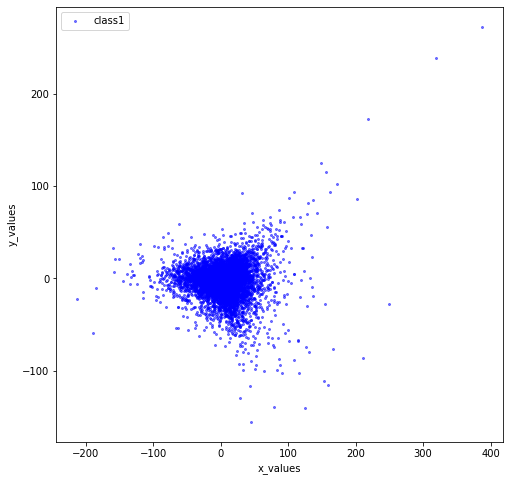

In [466]:
c1, c2 = 1, 3
tocluster = pd.DataFrame(ps[[c1,c2]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[c1], tocluster[c2], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [467]:
# plot_pca(4, 1)

In [468]:
# plot_pca(0, 1)

In [469]:
# plot_pca(1,2)

In [470]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=cluster_count,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[ -0.12031683   0.17819941]
 [ 34.13521654  -2.95463605]
 [-32.13038483  -0.26441998]]


In [471]:
print (c_preds[0:100])
print('c_preds.shape =', c_preds.shape)

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 2 0 0 2 1 0 0 0 0 0 0 0 0 0 0]
c_preds.shape = (49948,)


['orange', 'blue', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


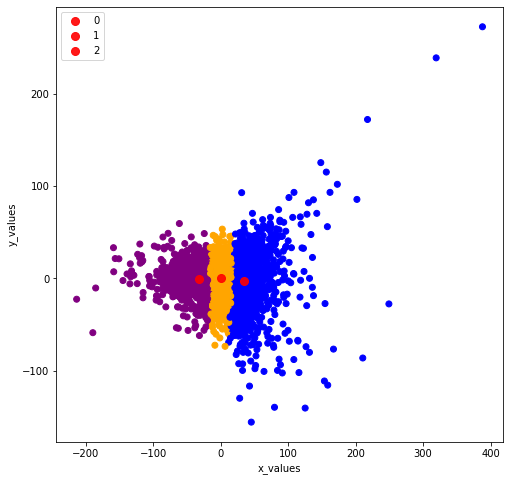

In [472]:
import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[c1],tocluster[c2],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [473]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

clust_prod.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,3,0,0,0,0,1,0,0,0,...,1,1,0,0,0,0,2,0,31,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0


(49948, 135)


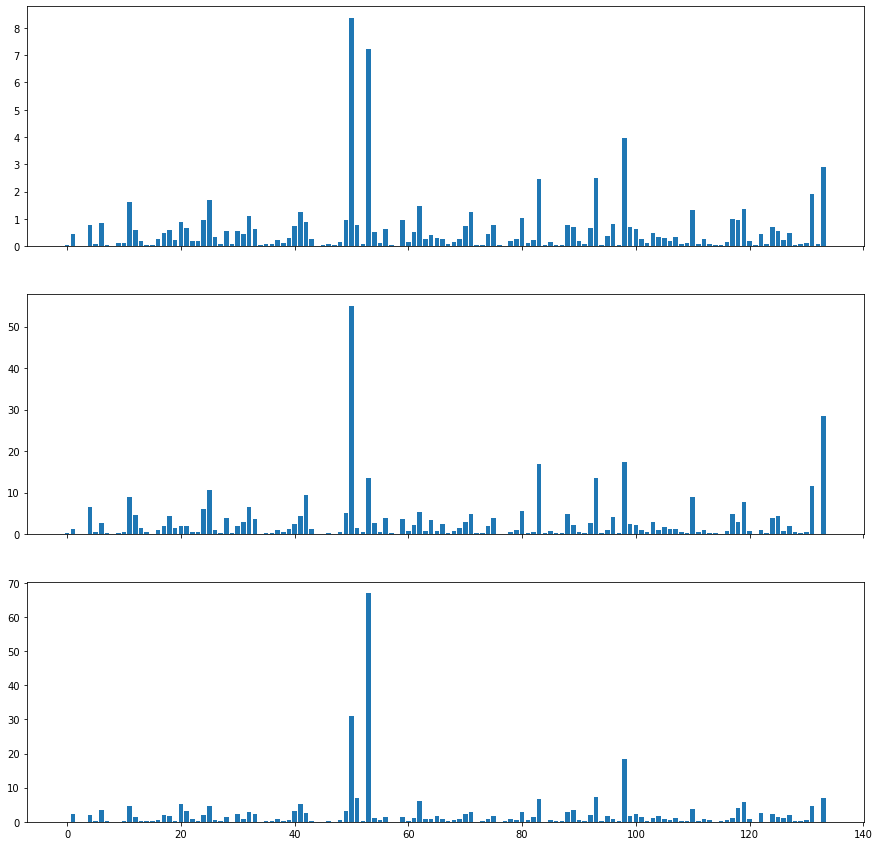

In [479]:
print (clust_prod.shape)
f,arr = plt.subplots(3,1,sharex=True,figsize=(15,15))

c1_count = len(clust_prod[clust_prod['cluster']==0])

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
arr[0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)

c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
arr[1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)

c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
arr[2].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c2)

# c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
# arr[1,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c3)

plt.show()

In [475]:
c0.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     8.366033
fresh vegetables                 7.221074
packaged vegetables fruits       3.955719
yogurt                           2.893298
packaged cheese                  2.482183
milk                             2.452040
water seltzer sparkling water    1.906880
chips pretzels                   1.700656
bread                            1.601601
frozen produce                   1.464355
dtype: float64

In [476]:
c1.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     55.071056
yogurt                           28.400241
packaged vegetables fruits       17.349659
milk                             16.959855
packaged cheese                  13.527900
fresh vegetables                 13.492975
water seltzer sparkling water    11.542754
chips pretzels                   10.666399
energy granola bars               9.503011
refrigerated                      9.013248
dtype: float64

In [477]:
c2.sort_values(ascending=False)[0:10]

aisle
fresh vegetables              66.915453
fresh fruits                  31.073625
packaged vegetables fruits    18.269417
packaged cheese                7.389563
yogurt                         7.003236
fresh herbs                    6.846278
milk                           6.603964
frozen produce                 5.965615
soy lactosefree                5.744337
eggs                           5.206311
dtype: float64

In [478]:
# c3.sort_values(ascending=False)[10:15]